# Visualize Results: Downstream Performance - "Corrupted" Experiment

This notebook should answer the questions: *Does imputation lead to better downstream performances?*

## Notebook Structure 

* Application Scenario 2 - Downstream Performance  
   * Categorical  Columns (Classification)
   * Numerical Columns (Regression)
   * Heterogenous Columns (Classification and Regression Combined)

In [27]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns

from pathlib import Path
from data_imputation_paper.experiment import read_experiment, read_csv_files
from data_imputation_paper.plotting import draw_cat_box_plot

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Settings

In [2]:
sns.set(style="whitegrid")
sns.set_context('paper', font_scale=1.5)
mpl.rcParams['lines.linewidth'] = '2'

In [25]:
EXPERIMENT = "corrupted"

EXPERIMENT_PATH = Path(f"../data/experiments/cluster5/{EXPERIMENT}/")
ALTERNATIVE_BASELINE_PATH = Path("../data/experiments/cluster5/alternative_baseline_aggregated.csv")

CLF_METRIC = "F1_macro"
REG_METRIC = "RMSE"

DOWNSTREAM_RESULT_TYPE = "downstream_performance_mean"
IMPUTE_RESULT_TYPE = "impute_performance_mean"

FIGURES_PATH = Path(f"../paper/figures/{EXPERIMENT}/{DOWNSTREAM_RESULT_TYPE}")

## Import the data

In [5]:
%%time

results = read_csv_files(read_experiment(EXPERIMENT_PATH), read_details=False)
results.head()

CPU times: user 1min 39s, sys: 3.88 s, total: 1min 43s
Wall time: 1min 51s


,experiment,imputer,task,missing_type,missing_fraction,strategy,column,result_type,metric,train,test,baseline,corrupted,imputed
0,corrupted,AutoKerasImputer,40922,MCAR,0.01,single_all,gyro_y,impute_performance_std,MAE,0.430927,1.316501,NaN,NaN,NaN
1,corrupted,AutoKerasImputer,40922,MCAR,0.01,single_all,gyro_y,impute_performance_std,MSE,12.367895,31.128048,NaN,NaN,NaN
2,corrupted,AutoKerasImputer,40922,MCAR,0.01,single_all,gyro_y,impute_performance_std,RMSE,0.716819,1.870398,NaN,NaN,NaN
3,corrupted,AutoKerasImputer,40922,MCAR,0.30,single_all,gyro_y,impute_performance_std,MAE,0.048134,0.108173,NaN,NaN,NaN
4,corrupted,AutoKerasImputer,40922,MCAR,0.30,single_all,gyro_y,impute_performance_std,MSE,1.479995,3.087714,NaN,NaN,NaN


In [6]:
na_impute_results = results[
    (results["result_type"] == IMPUTE_RESULT_TYPE) & 
    (results["metric"].isin([CLF_METRIC, REG_METRIC]))
]
na_impute_results.drop(["baseline", "corrupted", "imputed"], axis=1, inplace=True)
na_impute_results = na_impute_results[na_impute_results.isna().any(axis=1)]
na_impute_results.shape

(0, 11)

In [7]:
alt_base = pd.read_csv(ALTERNATIVE_BASELINE_PATH)
alt_base.columns = ["experiment", "task", "pattern", "fraction", "metric", "mean", "std"]
alt_base = alt_base[2:]

alt_base["fraction"] = pd.to_numeric(alt_base["fraction"])
alt_base["mean"] = pd.to_numeric(alt_base["mean"])
alt_base["std"] = pd.to_numeric(alt_base["std"])

alt_base = alt_base[alt_base["experiment"] == "experiment_2"]  # experiment_2 == corrupted
alt_base.drop(["experiment"], axis=1, inplace=True)

alt_base = alt_base[alt_base["metric"].isin([CLF_METRIC, REG_METRIC])]
alt_base

,task,pattern,fraction,metric,mean,std
2486,6,MAR,0.01,F1_macro,0.713819,0.000722
2489,6,MAR,0.10,F1_macro,0.682978,0.003279
2492,6,MAR,0.30,F1_macro,0.614997,0.002507
2495,6,MAR,0.50,F1_macro,0.583189,0.006060
2498,6,MCAR,0.01,F1_macro,0.716568,0.004043
...,...,...,...,...,...,...
4957,42712,MCAR,0.50,RMSE,147.258938,5.609923
4960,42712,MNAR,0.01,RMSE,140.647087,1.991546
4963,42712,MNAR,0.10,RMSE,143.763733,1.464394
4966,42712,MNAR,0.30,RMSE,144.371327,3.060331


In [8]:
downstream_results = results[
    (results["result_type"] == DOWNSTREAM_RESULT_TYPE) & 
    (results["metric"].isin([CLF_METRIC, REG_METRIC]))
]

# remove experiments where imputation failed
downstream_results = downstream_results.merge(
    na_impute_results,
    how = "left",
    validate = "one_to_one",
    indicator = True,
    suffixes=("", "_imp"),
    on = ["experiment", "imputer", "task", "missing_type", "missing_fraction", "strategy", "column"]
)
downstream_results = downstream_results[downstream_results["_merge"]=="left_only"]

assert len(results["strategy"].unique()) == 1
downstream_results.drop(["experiment", "strategy", "result_type_imp", "metric_imp", "train", "test", "train_imp", "test_imp", "_merge"], axis=1, inplace=True)

downstream_results = downstream_results.rename(
    {
        "imputer": "Imputer",
        "task": "Task",
        "missing_type": "Missing Type",
        "missing_fraction": "Missing Fraction",
        "column": "Column",
        "baseline": "Baseline",
        "corrupted": "Corrupted", 	
        "imputed": "Imputed"
    },
    axis = 1
)
print(downstream_results.shape)

# join alternative baseline
downstream_results = downstream_results.merge(
    alt_base,
    right_on = ["task", "pattern", "fraction", "metric"],
    left_on = ["Task", "Missing Type", "Missing Fraction", "metric"],
).drop(["task", "pattern", "fraction", "std"], axis=1)
downstream_results = downstream_results.rename(
    {"mean": "Baseline_2"},
    axis=1
)

downstream_results

(5616, 10)


,Imputer,Task,Missing Type,Missing Fraction,Column,result_type,metric,Baseline,Corrupted,Imputed,Baseline_2
0,AutoKerasImputer,40922,MCAR,0.01,gyro_y,downstream_performance_mean,F1_macro,0.701930,0.0,0.702019,0.724151
1,ModeImputer,40922,MCAR,0.01,gyro_y,downstream_performance_mean,F1_macro,0.701930,0.0,0.702123,0.724151
2,ForestImputer,40922,MCAR,0.01,gyro_y,downstream_performance_mean,F1_macro,0.708640,0.0,0.708875,0.724151
3,VAEImputer_0,40922,MCAR,0.01,gyro_y,downstream_performance_mean,F1_macro,0.701930,0.0,0.702087,0.724151
4,KNNImputer,40922,MCAR,0.01,gyro_y,downstream_performance_mean,F1_macro,0.708640,0.0,0.708824,0.724151
...,...,...,...,...,...,...,...,...,...,...,...
5611,ForestImputer,1220,MAR,0.50,keyword_id,downstream_performance_mean,F1_macro,0.462242,0.0,0.462286,0.491971
5612,VAEImputer_0,1220,MAR,0.50,keyword_id,downstream_performance_mean,F1_macro,0.468188,0.0,0.467203,0.491971
5613,KNNImputer,1220,MAR,0.50,keyword_id,downstream_performance_mean,F1_macro,0.461996,0.0,0.461726,0.491971
5614,VAEImputer_noise,1220,MAR,0.50,keyword_id,downstream_performance_mean,F1_macro,0.467151,0.0,0.467151,0.491971


### Check if results are complete

In [9]:
# should have equal length
downstream_results["Imputer"].value_counts(dropna=False)

VAEImputer_0        828
VAEImputer_noise    828
KNNImputer          828
ModeImputer         828
ForestImputer       825
GAINImputer         824
AutoKerasImputer    655
Name: Imputer, dtype: int64

### Robustness: check which imputers yielded `NaN`values

In [10]:
for col in downstream_results.columns:
    na_sum = downstream_results[col].isna().sum()
    if na_sum > 0:
        print("-----" * 10)        
        print(col, na_sum)
        print("-----" * 10)        
        na_idx = downstream_results[col].isna()
        print(downstream_results.loc[na_idx, "Imputer"].value_counts(dropna=False))
        print("\n")

## Compute Downstream Performance relative to Baseline

In [11]:
clf_row_idx = downstream_results["metric"] == CLF_METRIC
reg_row_idx = downstream_results["metric"] == REG_METRIC

In [12]:
downstream_results["Improvement"]   = (downstream_results["Imputed"] - downstream_results["Baseline"]  ) / downstream_results["Baseline"]
downstream_results["Improvement_2"] = (downstream_results["Imputed"] - downstream_results["Baseline_2"]) / downstream_results["Baseline_2"]
downstream_results.loc[reg_row_idx, "Improvement"]   = downstream_results.loc[reg_row_idx, "Improvement"]   * -1
downstream_results.loc[reg_row_idx, "Improvement_2"] = downstream_results.loc[reg_row_idx, "Improvement_2"] * -1

downstream_results

,Imputer,Task,Missing Type,Missing Fraction,Column,result_type,metric,Baseline,Corrupted,Imputed,Baseline_2,Improvement,Improvement_2
0,AutoKerasImputer,40922,MCAR,0.01,gyro_y,downstream_performance_mean,F1_macro,0.701930,0.0,0.702019,0.724151,0.000126,-0.030563
1,ModeImputer,40922,MCAR,0.01,gyro_y,downstream_performance_mean,F1_macro,0.701930,0.0,0.702123,0.724151,0.000274,-0.030419
2,ForestImputer,40922,MCAR,0.01,gyro_y,downstream_performance_mean,F1_macro,0.708640,0.0,0.708875,0.724151,0.000332,-0.021095
3,VAEImputer_0,40922,MCAR,0.01,gyro_y,downstream_performance_mean,F1_macro,0.701930,0.0,0.702087,0.724151,0.000223,-0.030469
4,KNNImputer,40922,MCAR,0.01,gyro_y,downstream_performance_mean,F1_macro,0.708640,0.0,0.708824,0.724151,0.000260,-0.021165
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5611,ForestImputer,1220,MAR,0.50,keyword_id,downstream_performance_mean,F1_macro,0.462242,0.0,0.462286,0.491971,0.000093,-0.060339
5612,VAEImputer_0,1220,MAR,0.50,keyword_id,downstream_performance_mean,F1_macro,0.468188,0.0,0.467203,0.491971,-0.002105,-0.050344
5613,KNNImputer,1220,MAR,0.50,keyword_id,downstream_performance_mean,F1_macro,0.461996,0.0,0.461726,0.491971,-0.000585,-0.061477
5614,VAEImputer_noise,1220,MAR,0.50,keyword_id,downstream_performance_mean,F1_macro,0.467151,0.0,0.467151,0.491971,0.000000,-0.050449


In [13]:
downstream_results.groupby("metric")["Improvement", "Improvement_2"].describe().round(3).transpose()

metric               F1_macro      RMSE
Improvement   count  3904.000  1712.000
              mean      0.000    -0.008
              std       0.017     0.200
              min      -0.242    -7.744
              25%      -0.002    -0.002
              50%       0.000    -0.000
              75%       0.002     0.001
              max       0.346     0.308
Improvement_2 count  3904.000  1712.000
              mean      0.039     0.071
              std       0.145     0.235
              min      -0.367    -6.736
              25%      -0.007    -0.004
              50%       0.009     0.019
              75%       0.049     0.095
              max       1.247     0.764

In [14]:
downstream_results.groupby("metric")["Improvement", "Improvement_2"].mean().round(3)

,Improvement,Improvement_2
metric,,
F1_macro,0.000,0.039
RMSE,-0.008,0.071


In [15]:
downstream_results.groupby("metric")["Improvement", "Improvement_2"].median().round(3)

,Improvement,Improvement_2
metric,,
F1_macro,0.0,0.009
RMSE,-0.0,0.019


## Application Scenario 2 - Downstream Performance

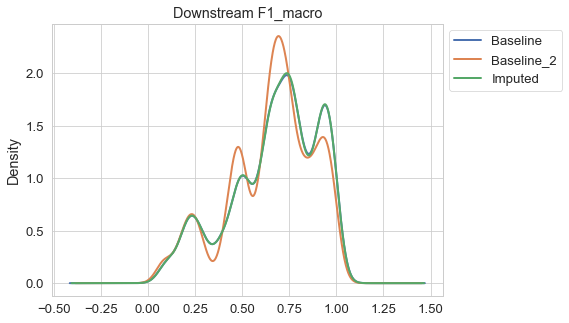

In [16]:
downstream_results.loc[clf_row_idx,["Baseline", "Baseline_2", "Imputed"]].plot(kind="kde", title=f"Downstream {CLF_METRIC}", figsize=(7,5))
plt.legend(bbox_to_anchor=(1,1), loc="upper left") #place legend in top right corner

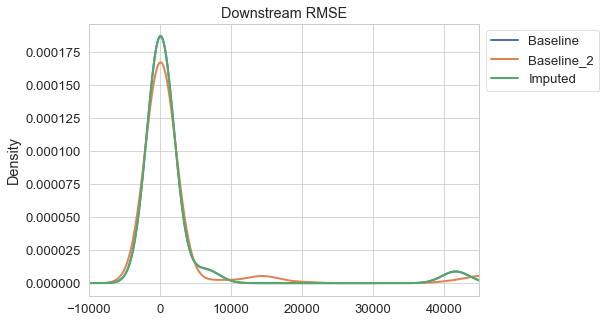

In [17]:
downstream_results.loc[reg_row_idx,["Baseline", "Baseline_2", "Imputed"]].plot(kind="kde", title=f"Downstream {REG_METRIC}", figsize=(7,5), xlim=(-10000, 45000))
plt.legend(bbox_to_anchor=(1,1), loc="upper left") #place legend in top right corner

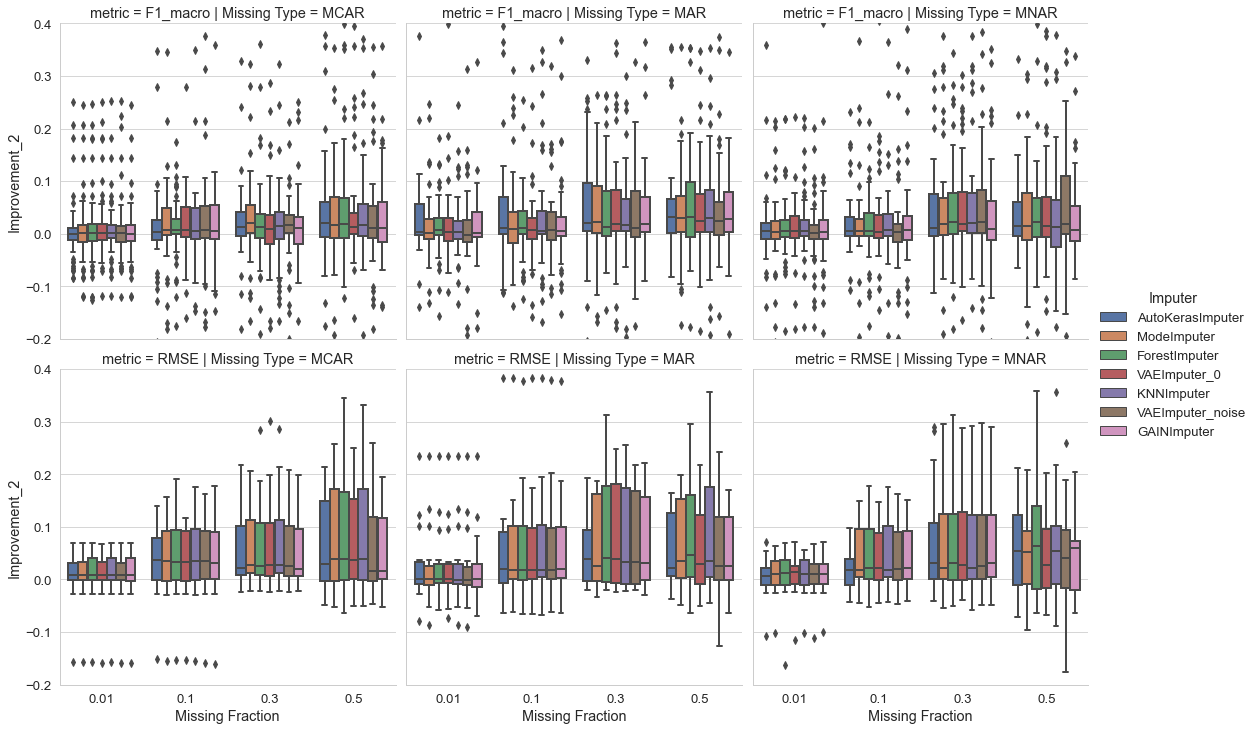

In [39]:
draw_cat_box_plot(
    downstream_results,
    "Improvement_2",
    (-0.2, 0.4),
    FIGURES_PATH,
    "improvement_boxplot.svg"
)